In [37]:
import osmnx 
import matplotlib.pyplot as plt
import contextily
import pandas as pd
import numpy as np
import shapely.geometry
import geopandas
import folium

In [38]:
def get_shortest_route(graph, origin, destination):
    """Calculates the shortest route in a graph between an origin point and destination point

    Args:
        graph (networkx.classes.multidigraph.MultiDiGraph): network graph from openstreetmap data
        origin (shapely.geometry.point.Point): point geometry represented by coordinates of origin
        destination (shapely.geometry.point.Point): point geometry represented by coordinates of destination

    Returns:
        list: shortest path as list of node ids
    """
    origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
    destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
    
    return osmnx.shortest_path(graph, origin_node_id, destination_node_id)


def calculate_shortest_route_length(origin_name, destination_name, graph, graph_edges):
    """calculate_shortest_route_length 

    Args:
        origin_name (str): name of specified origin location
        destination_name (list): name of specified destination location(s)
        graph (networkx.classes.multidigraph.MultiDiGraph): network graph from openstreetmap data
        graph_edges (geopandas.geodataframe.GeoDataFrame): graph edge information in a geodataframe

    Returns:
        pd.DataFrame: dataframe containing 3 columns
            - name: destination name
            - route: shortest route as list of route nodes
            - route_length: length of shortest route
    """
    # only accept destination_name as a list
    assert isinstance(destination_name, (list, np.ndarray)), 'destination_name should be a list or numpy array'

    origin = (
        osmnx.geocode_to_gdf(origin_name)
        .to_crs(graph_edges.crs)  
        .at[0, "geometry"]
        .centroid   # use the centre point
    )

    # for multiple destination names
    if len(destination_name) > 1:

         # store route details 
        route_lengths = []
        routes = []
        dest_names = []

        for name in destination_name:
            
            # adjusted name to be more specific
            location_name = f'{name}, Victoria, Australia'

            destination = (
                osmnx.geocode_to_gdf(location_name)
                .to_crs(graph_edges.crs)
                .at[0, "geometry"]
                .centroid
            )

            route = get_shortest_route(graph, origin, destination)

            route_length = osmnx.routing.route_to_gdf(graph, route)['length'].sum()

            dest_names.append(location_name)
            routes.append(route)
            route_lengths.append(route_length)

        df_routes = pd.DataFrame({'name':dest_names, 'route':routes, 'route_length':route_lengths})

        shortest = df_routes.iloc[[df_routes.route_length.idxmin()]].reset_index()


    # for a single destination
    else:
        
        # adjusted name to be more specific
        location_name = f'{destination_name[0]}, Victoria, Australia'

        destination = (
            osmnx.geocode_to_gdf(location_name)
            .to_crs(graph_edges.crs)
            .at[0, "geometry"]
            .centroid
        )

        route = get_shortest_route(graph, origin, destination)
        route_length = osmnx.routing.route_to_gdf(graph, route)['length'].sum()

        shortest = pd.DataFrame({'name':location_name, 'route':[route], 'route_length':route_length})

    return shortest

In [39]:
# get details from address 
PLACE_NAME = "Doncaster, Victoria, Australia"

# desired feature
tags = {'building':'sports_centre'}

# specified radius around address
distance = 5000

# geodataframe containing information of desired features within specified radius
gdf = osmnx.features.features_from_address(
    PLACE_NAME, 
    tags, 
    dist=distance)

# travel method
travel_type = 'bike'

In [40]:
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)
place_polygon = place_polygon.to_crs("EPSG:3067")           # reproject so CRS unit is meters
place_polygon["geometry"] = place_polygon.buffer(5000)      # Buffer by 5000 meters
place_polygon = place_polygon.to_crs("EPSG:4326")           # reproject back to required form for osmnx

# get network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type=travel_type
)

# project graph to appropriate UTM zone
graph = osmnx.project_graph(graph) 

# extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)

In [41]:
# get name of sports centres in radius 
sports_centres = gdf.name.dropna().values

# desired starting point
origin_name = "Ruffey Lake Park, Victoria, Australia"

In [42]:
# get shortest route and associated information from list of destinations
df_shortest = calculate_shortest_route_length(origin_name, sports_centres, graph, edges)
route = df_shortest.at[0, 'route']

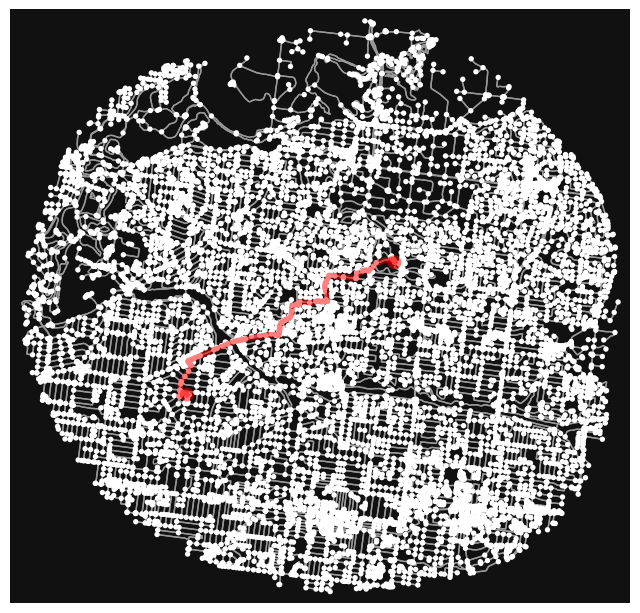

In [43]:
# simple plot using osmnx method
fig, ax = osmnx.plot_graph_route(graph, route)

Creating static map for shortest route

In [44]:
# get specific route_nodes from node ids
route_nodes = nodes.loc[route]

# geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

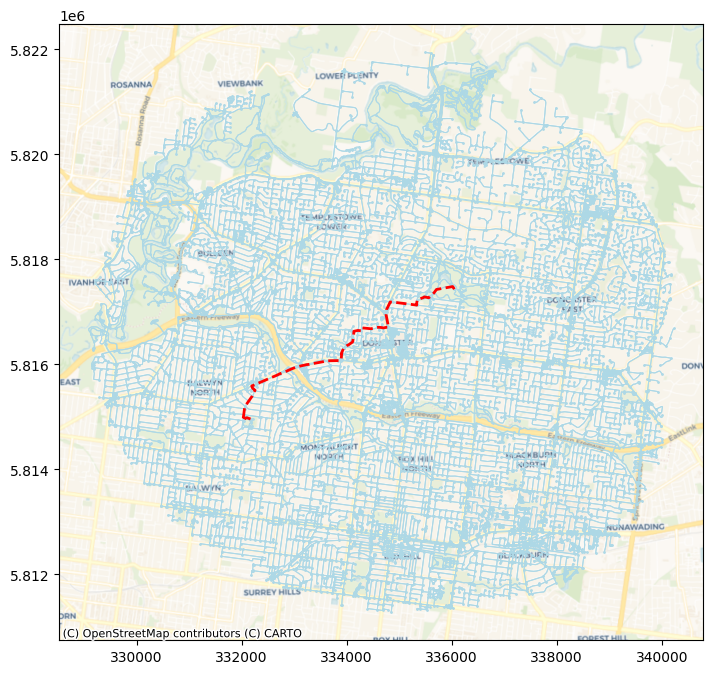

In [45]:
# static map
fig, ax = plt.subplots(figsize=(12,8))

# plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='lightblue')
nodes.plot(ax=ax, markersize=1, color='lightblue')

# plot route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# basemap
contextily.add_basemap(ax, crs=edges.crs, source=contextily.providers.CartoDB.Voyager)

Creating interactive map for shortest route

In [46]:
origin = osmnx.geocode_to_gdf(origin_name)
origin_location = [origin.lat[0], origin.lon[0]]

# initialise map
interactive_map = folium.Map(
    location=origin_location,
    zoom_start=14,
    control_scale=True,
    tiles="cartodbvoyager"    
)

# origin marker
origin_marker = folium.Marker(
    location=origin_location,
    tooltip=origin.display_name[0],
    icon=folium.Icon(color="green", icon="home")
)

origin_marker.add_to(interactive_map)


# destination marker
destination = osmnx.geocode_to_gdf(df_shortest.name[0])
destination_location = [destination.lat[0], destination.lon[0]]

destination_marker = folium.Marker(
    location=destination_location,
    tooltip=df_shortest.name[0],
    icon=folium.Icon(color="blue", icon="ok-sign")
)

destination_marker.add_to(interactive_map)


# shortest route to destination
route_locations = route_nodes[['lat','lon']].values

map_route = folium.PolyLine(
    locations=route_locations,
    color='red'
)

map_route.add_to(interactive_map)

In [47]:
interactive_map

In [48]:
interactive_map.save("shortest_route.html")